# p-Kinematic hardening - with additive viscous term

This example gives the numerical implementation of the viscous parallel kinematic hardening model.

For background, see: Houlsby et al. (2017) A model for nonlinear hysteretic and ratcheting behaviour. _International Journal of Solids and Structures_ __120__ 67-80.

The Gibbs free energy $g$ and the flow potential $w$ for this model are given by:

\begin{align*}
g = & -\frac{\left( \sigma + \sum_{n=1}^{N} H_n \alpha_n \right)^2}{2E_0}  + \frac{1}{2} \sum_{n=1}^N H_n \alpha_n^2\\
w = & \frac{1}{2\mu} \sum_{n=1}^{N} \langle |\chi_n| - k_n \rangle^2
\end{align*}

The incremental response follows from a standardised approach, which can be written in the following form:

\begin{align*}
-\dot{\epsilon} & = \frac{\partial^2 g}{\partial \sigma^2} \dot{\sigma} + \sum_{n=1}^{N} \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\alpha}_n \\
-\dot{\bar{\chi}}_n & = \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} + \sum_{m=1}^{N} \frac{\partial^2 g}{\partial \alpha_m \partial \alpha_n} \dot{\alpha}_n  
\end{align*}

The rate of hardening strain is defined by:

\begin{equation*}
\dot{\alpha}_n = \frac{\partial w}{\partial \chi_n}
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from discretise_kinematic_hardening import discretise_kinematic_hardening_parallel

In [2]:
def macaulay(x):
    x[x<0] = 0
    return x

In [3]:
# The implementation of the above equations is given below

# Model parameters
sigma_backbone = np.array([0.2, 0.4, 0.6, 0.8, 1])
epsilon_backbone = np.array([0.2, 0.6, 1.2, 2.0, 3.0])

k_n, H_n = discretise_kinematic_hardening_parallel(sigma_backbone, epsilon_backbone)
k_n = np.asarray(np.transpose(np.matrix(k_n)))
H_n = np.asarray(np.transpose(np.matrix(H_n)))

E_0 = np.sum(H_n)

# Initialise the model state parameters
epsilon = 0
chi_n = np.zeros_like(H_n)
alpha_n = np.zeros_like(H_n)

# Define the applied stress history
sigma_max_abs_1 = 0.9
sigma_max_abs_2 = 0

d_sigma_abs = 0.002

sigma_loop = np.append(np.arange(0, sigma_max_abs_1, d_sigma_abs), 
                np.arange(sigma_max_abs_1, -sigma_max_abs_2, -d_sigma_abs))

sigma_history = np.tile(sigma_loop, 10)
epsilon_history = np.zeros(len(sigma_history))

d2_g_d_s2 = -1/E_0
d2_g_d_an2 = -np.matmul(H_n, np.transpose(H_n))/(E_0) + np.diag(H_n[:,0])
d2_g_d_san = -np.transpose(H_n) / E_0
d2_g_d_ans = -H_n / E_0

sigma_0 = 0

mu = 0.01
dt = 0.1

# Calculate the incremental response
for index, sigma in enumerate(sigma_history):
        
    d_sigma = sigma - sigma_0
            
    d_w_d_chi_n = 1 / mu * macaulay(np.abs(chi_n) - k_n) * np.sign(chi_n)
                    
    d_alpha_n = d_w_d_chi_n * dt
        
    d_epsilon = - (d2_g_d_s2 * d_sigma + np.matmul(d2_g_d_san, d_alpha_n))
    d_chi_n = - (d2_g_d_ans * d_sigma + np.matmul(d2_g_d_an2, d_alpha_n))
            
    epsilon = epsilon + d_epsilon
    chi_n = chi_n + d_chi_n
    alpha_n = alpha_n + d_alpha_n
    
    sigma_0 = sigma
            
    epsilon_history[index] = epsilon   

Text(0,0.5,'$\\sigma$')

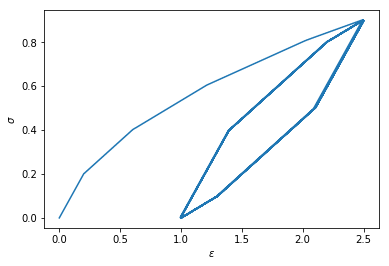

In [4]:
plt.plot(epsilon_history, sigma_history)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')